# Weather dataset

These are the results from [London Weather Dataset](https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data) from Kaggle. The dataset describes the London weather conditions day by day starting from 01-01-1979 to 31-12-2020.  The dataset has an amount of 15341 observations and 10 attributes: 

- date - recorded date of measurement - (int)
- cloud_cover - cloud cover measurement in oktas - (float)
- global_radiation - irradiance measurement in Watt per square meter (W/m2) - (float)
- max_temp - maximum temperature recorded in degrees Celsius (°C) - (float)
- mean_temp - mean temperature in degrees Celsius (°C) - (float)
- min_temp - minimum temperature recorded in degrees Celsius (°C) - (float)
- pressure - pressure measurement in Pascals (Pa) - (float)

Only a part $\simeq5000$ rows of the original dataset have been used, being first preprocessed to respect the requirements needed for training the model, mainly dropping null values and dividing the time stamp into separated columns for each day, month and year.

## Imports and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.spatial.distance import cdist
from scipy import stats
from statsmodels.tsa.stattools import acf

In [2]:
df = pd.read_csv('../Real_Datasets/London_original.csv')
df.dropna(inplace=True)
df_filtered = df.iloc[0:3000]

In [3]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              3000 non-null   object 
 1   cloud_cover       3000 non-null   float64
 2   global_radiation  3000 non-null   float64
 3   max_temp          3000 non-null   float64
 4   mean_temp         3000 non-null   float64
 5   min_temp          3000 non-null   float64
 6   pressure          3000 non-null   float64
dtypes: float64(6), object(1)
memory usage: 164.2+ KB


## Synthetic data import

The dataset so preprocessed has been used to train the generative model. After that the synthetic data are here imported and preprocessed. Since the generation could not always work fine, the data are sometimes misgenerated in wrong format or completely out of bounds (for instance a temperature of 10k ºC), or even not generated. Thus the first thing done here is to convert, if needed, the data in the original format, remove the missing values and the values somehow out of the original values ranges, ensuring that these are relxed to admit values out of the proper ranges but still significative for the analysis.

In [4]:
df_sin = pd.read_csv('synt_datasets/London_Weather_original_fromprompts.csv')

In [5]:
df_sin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              3000 non-null   object 
 1   cloud_cover       2988 non-null   float64
 2   global_radiation  2981 non-null   float64
 3   max_temp          2997 non-null   float64
 4   mean_temp         2996 non-null   float64
 5   min_temp          2996 non-null   float64
 6   pressure          3000 non-null   float64
dtypes: float64(6), object(1)
memory usage: 164.2+ KB


In [6]:
df_sin['global_radiation'] = pd.to_numeric( df_sin['global_radiation'], errors='coerce')
df_sin['pressure'] = pd.to_numeric( df_sin['pressure'], errors='coerce')
df_sin.dropna(inplace=True)


In [7]:
df_sin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2960 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2960 non-null   object 
 1   cloud_cover       2960 non-null   float64
 2   global_radiation  2960 non-null   float64
 3   max_temp          2960 non-null   float64
 4   mean_temp         2960 non-null   float64
 5   min_temp          2960 non-null   float64
 6   pressure          2960 non-null   float64
dtypes: float64(6), object(1)
memory usage: 185.0+ KB


In [8]:
columns = df_filtered.columns.to_list()
excluded_columns = ['date', 'cloud_cover']

for col in columns:
    if col not in excluded_columns:    
        print('\n', col, '\n\nReal ranges: ',  ' min ', df_filtered[col].min(), ' max ', df_filtered[col].max(),
              '\nSynthetic ranges: ', ' min ', df_sin[col].min(), ' max ', df_sin[col].max(),)


 global_radiation 

Real ranges:   min  12.0  max  348.0 
Synthetic ranges:   min  1.0  max  101370.0

 max_temp 

Real ranges:   min  -6.2  max  32.8 
Synthetic ranges:   min  -3.5  max  31.6

 mean_temp 

Real ranges:   min  -7.6  max  26.0 
Synthetic ranges:   min  -8.2  max  24.6

 min_temp 

Real ranges:   min  -11.8  max  19.1 
Synthetic ranges:   min  -8.9  max  24.0

 pressure 

Real ranges:   min  97680.0  max  104280.0 
Synthetic ranges:   min  2.0  max  1001982.0


We see the `pressure` variable has misgenerated values that we now remove considering only values in the range of the real $\pm30000$

In [9]:
df_sin = df_sin[df_sin['global_radiation'] <= 500.0]


df_sin = df_sin[df_sin['pressure'] >= 65960.0]
df_sin = df_sin[df_sin['pressure'] <= 134430.0]

df_sin = df_sin[df_sin['cloud_cover'] <= 8.0]


In [10]:
df_sin['cloud_cover'] = df_sin['cloud_cover'].astype('int')
df_filtered['cloud_cover'] = df_filtered['cloud_cover'].astype('int')

/var/folders/k9/h78k3gpn65g5ws_c46j649n40000gn/T/ipykernel_8366/3533141850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cloud_cover'] = df_filtered['cloud_cover'].astype('int')


In [11]:
df_sin['cloud_cover'] = df_sin['cloud_cover'].astype('category')
df_filtered['cloud_cover'] = df_filtered['cloud_cover'].astype('category')

/var/folders/k9/h78k3gpn65g5ws_c46j649n40000gn/T/ipykernel_8366/54023792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cloud_cover'] = df_filtered['cloud_cover'].astype('category')


## EDA confront between synthetic and real values

Here we dive a first sight to the continue variables marginal distributions of both the real and synthetic data, in order to check that the model has been able to catch the main properties of the data.

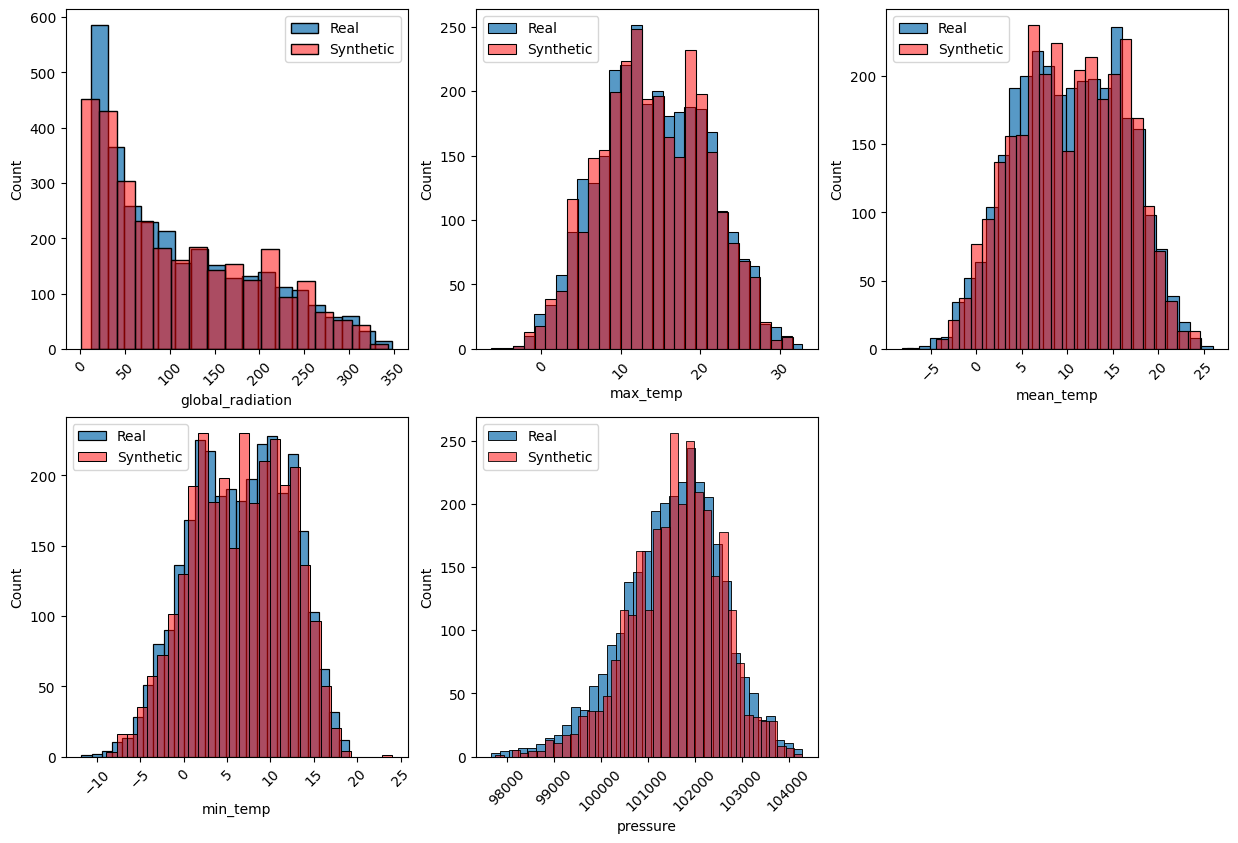

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
cols_to_plot = [
 'global_radiation',
 'max_temp',
 'mean_temp',
 'min_temp',
 'pressure',
 ]
plt.figure(figsize=(15, 15))
for i, col in enumerate(cols_to_plot):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df_filtered, x=col, label='Real')
    sns.histplot(data=df_sin, x=col, color='red', alpha=0.5, label='Synthetic')
    plt.xticks(rotation=45)
    plt.legend()

In [13]:
df_real = df_filtered.copy()
df_synthetic = df_sin.copy()

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

kl_divergences = {}

for column in cols_to_plot:

    real_hist, _ = np.histogram(df_real[column], bins=50, density=True)
    synth_hist, _ = np.histogram(df_synthetic[column], bins=50, density=True)
    
    
    real_hist = real_hist + 1e-10
    synth_hist = synth_hist + 1e-10
    
    
    real_hist = real_hist / np.sum(real_hist)
    synth_hist = synth_hist / np.sum(synth_hist)
    
    
    kl_div = kl_divergence(real_hist, synth_hist)
    kl_divergences[column] = kl_div

print("KL Divergences:")
for column, kl_div in kl_divergences.items():
    print(f"{column}: {kl_div:.2f}")

KL Divergences:
global_radiation: 0.39
max_temp: 0.04
mean_temp: 0.09
min_temp: 1.36
pressure: 0.03


In order to check the temporal properties of the data we set the timestamp back to the original format, so that the models can handle it.

In [14]:
df_sin.rename(columns={'date': 'Date'}, inplace=True)
df_filtered.rename(columns={'date': 'Date'}, inplace=True)

df_sin['Date'] = pd.to_datetime(df_sin['Date'], format='%d-%m-%Y')
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'],  format='%d-%m-%Y')


/var/folders/k9/h78k3gpn65g5ws_c46j649n40000gn/T/ipykernel_8366/1033482300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns={'date': 'Date'}, inplace=True)
/var/folders/k9/h78k3gpn65g5ws_c46j649n40000gn/T/ipykernel_8366/1033482300.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['Date'],  format='%d-%m-%Y')


/var/folders/k9/h78k3gpn65g5ws_c46j649n40000gn/T/ipykernel_8366/2253966353.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


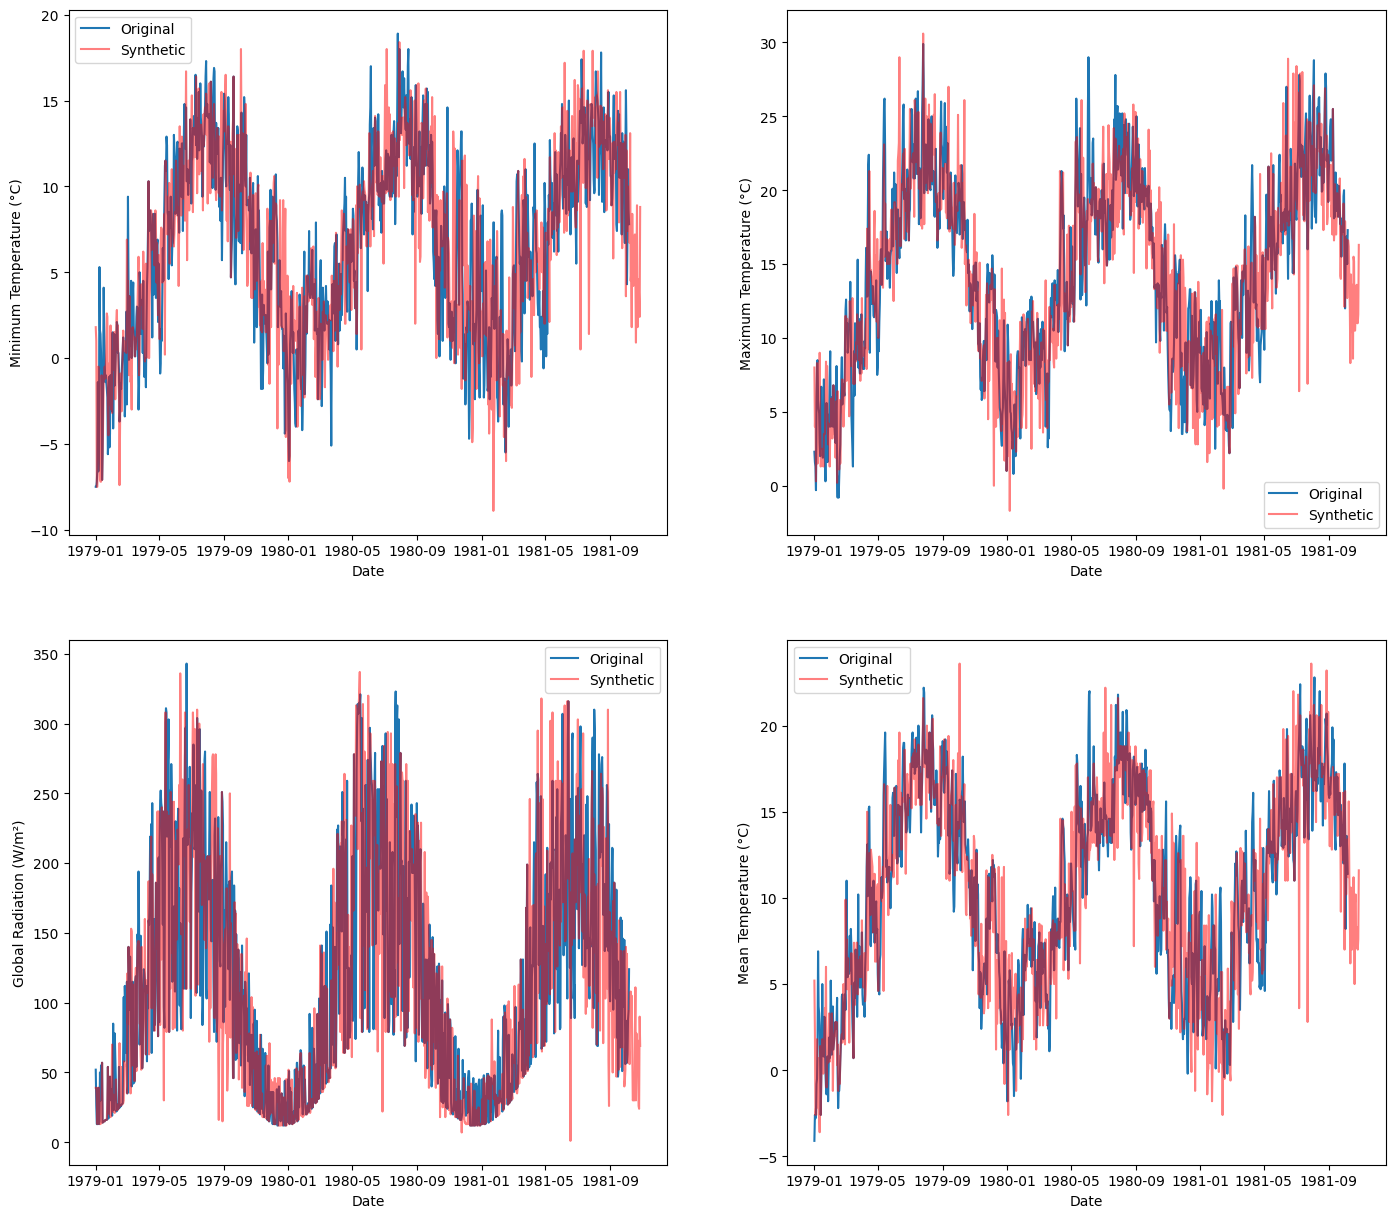

In [15]:
figure, ax = plt.subplots(2, 2, figsize=(17, 15))

ax1 = ax[0]
ax2 = ax[1]

ax1[0].plot(df_filtered.iloc[0:1000]['Date'], df_filtered.iloc[0:1000]['min_temp'], label='Original')
ax1[0].plot(df_sin.iloc[0:1000]['Date'], df_sin.iloc[0:1000]['min_temp'], color='red', alpha=0.5, label='Synthetic')
ax1[0].set_xlabel("Date")
ax1[0].set_ylabel("Minimum Temperature (°C)")
ax1[0].legend()

ax1[1].plot(df_filtered.iloc[0:1000]['Date'], df_filtered.iloc[0:1000]['max_temp'], label='Original')
ax1[1].plot(df_sin.iloc[0:1000]['Date'], df_sin.iloc[0:1000]['max_temp'], color='red', alpha=0.5, label='Synthetic')
ax1[1].set_xlabel("Date")
ax1[1].set_ylabel("Maximum Temperature (°C)")
ax1[1].legend()

ax2[0].plot(df_filtered.iloc[0:1000]['Date'], df_filtered.iloc[0:1000]['global_radiation'], label='Original')
ax2[0].plot(df_sin.iloc[0:1000]['Date'], df_sin.iloc[0:1000]['global_radiation'], color='red', alpha=0.5, label='Synthetic')
ax2[0].set_xlabel("Date")
ax2[0].set_ylabel("Global Radiation (W/m²)")
ax2[0].legend()

ax2[1].plot(df_filtered.iloc[0:1000]['Date'], df_filtered.iloc[0:1000]['mean_temp'], label='Original')
ax2[1].plot(df_sin.iloc[0:1000]['Date'], df_sin.iloc[0:1000]['mean_temp'], color='red', alpha=0.5, label='Synthetic')
ax2[1].set_xlabel("Date")
ax2[1].set_ylabel("Mean Temperature (°C)")
ax2[1].legend()

figure.show()

In [16]:
df_real = df_filtered.drop(columns=['Date', 'cloud_cover'])
df_synthetic = df_sin.drop(columns=['Date', 'cloud_cover'])

max_lag = 3  
autocorrelations = {}

for column in df_real.columns:
    real_acf = acf(df_real[column], nlags=max_lag)
    synth_acf = acf(df_synthetic[column], nlags=max_lag)
    
    autocorrelations[column] = {
        'real': real_acf,
        'synthetic': synth_acf
    }


print("\nAutocorrelations:")
for column, acfs in autocorrelations.items():
    print(f"\n{column}:")
    print("Lag\tReal\tSynthetic")
    for lag in range(max_lag + 1):
        print(f"{lag}\t{acfs['real'][lag]:.4f}\t{acfs['synthetic'][lag]:.4f}")


Autocorrelations:

global_radiation:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.7590	0.6796
2	0.7146	0.6857
3	0.6905	0.6905

max_temp:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.9273	0.8026
2	0.8767	0.8019
3	0.8437	0.8003

mean_temp:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.9427	0.8319
2	0.8876	0.8221
3	0.8519	0.8188

min_temp:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.8704	0.7579
2	0.7837	0.7470
3	0.7479	0.7432

pressure:
Lag	Real	Synthetic
0	1.0000	1.0000
1	0.8027	0.2384
2	0.5498	0.2340
3	0.3782	0.2220


## Evaluation

We now evaluate the quality of the data. 

### Copied values

First of all we'd like to have an insight on the synthetic data row-wise, we check if row by row there are copied values of the real data and, if there, how many they are.

In [17]:
def compute_equals(df1, df2, col_to_drop):

    df1['Date'] = pd.to_datetime(df1['Date'], format='%d-%m-%Y')
    df2['Date'] = pd.to_datetime(df2['Date'], format='%d-%m-%Y')
    
    matching_df1 = df1[df1['Date'].isin(df2['Date'])].copy()
    matching_df2 = df2[df2['Date'].isin(df1['Date'])].copy()
    original_indices = matching_df2.index
    
    matching_df1 = matching_df1.sort_values(by='Date').reset_index(drop=True)
    matching_df2 = matching_df2.sort_values(by='Date').reset_index(drop=True)

    matching_df1 = matching_df1.drop(columns=col_to_drop)
    matching_df2 = matching_df2.drop(columns=col_to_drop)

    numeric_cols = matching_df1.select_dtypes(include=[np.number]).columns
    
    results = []
    columns_matched = []
    summary_counter = Counter()
    matched_indices = []

    for i in range(len(matching_df1)):

        common_values = (matching_df1.loc[i, numeric_cols] == matching_df2.loc[i, numeric_cols])
        count_common = common_values.sum()
        matched_columns = numeric_cols[common_values].tolist()
        
        results.append(count_common)
        columns_matched.append(matched_columns)
        
        summary_counter.update(matched_columns)
        
        if count_common > 0:
            matched_indices.append({'index': original_indices[i], 'matched_columns': matched_columns})

    summary_report = dict(summary_counter)

    return results, columns_matched, summary_report, matched_indices


Since `cloud_cover` is a categorical variable in range [1,8], this variable to be correctly genereated should be equal to the real, thus it makes no sense to check if its values are different from the real values. 

In [18]:
cols_to_drop = ['cloud_cover']

In [19]:
distances, _, report, _ = compute_equals(df_filtered, df_sin, cols_to_drop)

/var/folders/k9/h78k3gpn65g5ws_c46j649n40000gn/T/ipykernel_8366/3124348240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['Date'], format='%d-%m-%Y')


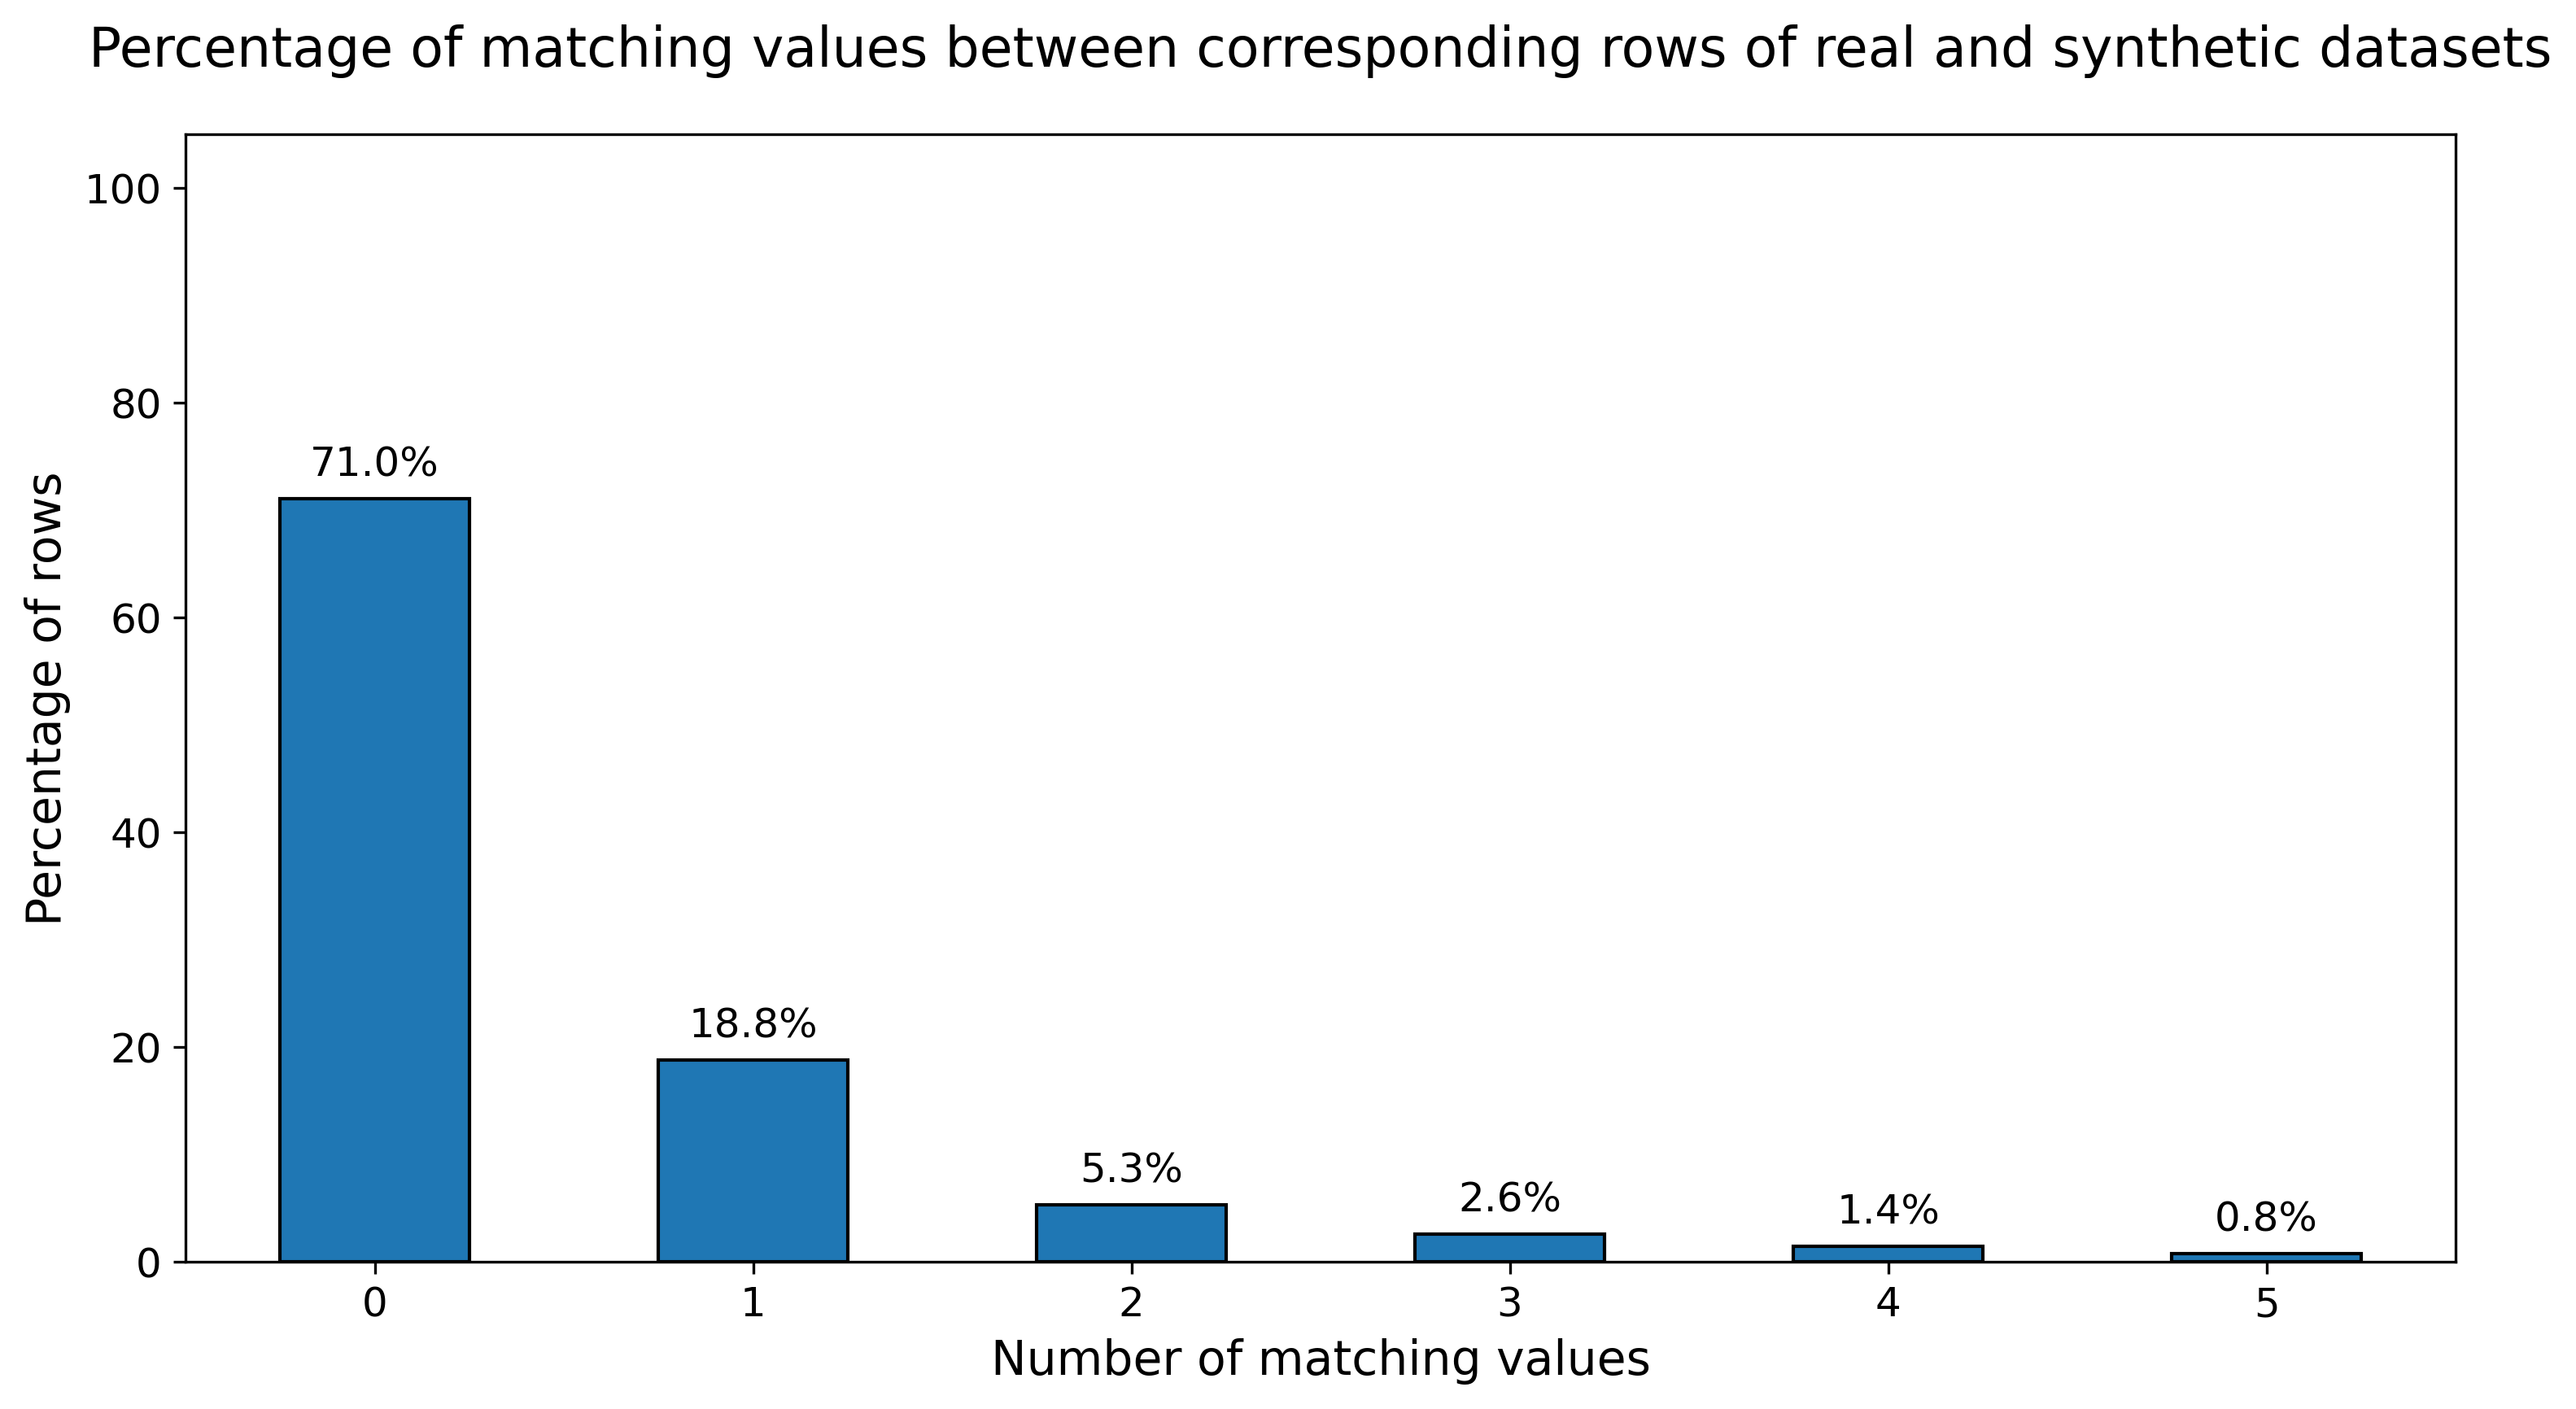

In [20]:
occurrences = pd.Series(distances).value_counts().sort_index()/len(distances) *100

plt.figure(figsize=(12, 6), dpi=300)
ax = occurrences.plot(kind='bar', color='#1f77b4', edgecolor='black')

plt.xlabel('Number of matching values', fontsize=14)
plt.ylabel('Percentage of rows', fontsize=14)
plt.title('Percentage of matching values between corresponding rows of real and synthetic datasets', fontsize=16, pad=20)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=12,
                color='black')

plt.ylim(0, 105)

plt.show()

In [21]:
print("Report of Copied Variables:\n")
for variable, value in report.items():
    print(f"{variable.replace('_', ' ').capitalize()}: {value}")

Report of Copied Variables:

Global radiation: 522
Max temp: 212
Pressure: 278
Mean temp: 188
Min temp: 168


### Discriminator

Another useful analysis can be conducted by implementing a ML discriminator that tries to detect synthetic data, in order to evaluate if these present any pattern that a ML model could find. We then implmented a RandomForest classifier, the datasets have been first labeled as `Real: 0` or `Synthetic: 1`, then merged and shuffled. On the merged dataset a static train-test-split has been applied and the classifier has been first trained and the tested.

In [22]:
def discriminator(real_data, synth_data):
    
    real_data['Synthetic'] = 0

    synth_data['Synthetic'] = 1
    
    combined_data = pd.concat([real_data, synth_data], axis=0)
    
    shuffled_df = combined_data.sample(frac=1).reset_index(drop=True)
    
    X = shuffled_df.drop('Synthetic', axis=1)
    y = shuffled_df['Synthetic']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    rf = RandomForestClassifier(n_estimators=100)

    rf.fit(X_train, y_train)

    predictions = rf.predict(X_test)

    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    print('Accuracy: ', round(accuracy_score(y_test, predictions), 2))

In [23]:
df_F = df_filtered.drop(['Date'], axis=1)
df_S = df_sin.drop(['Date'], axis=1)

In [24]:
discriminator(df_F, df_S)

[[413 457]
 [569 341]]
              precision    recall  f1-score   support

           0       0.42      0.47      0.45       870
           1       0.43      0.37      0.40       910

    accuracy                           0.42      1780
   macro avg       0.42      0.42      0.42      1780
weighted avg       0.42      0.42      0.42      1780

Accuracy:  0.42


### Distance to the closest record (DCR)

To quantify the similarity between synthetic data and original data, we use a distance to closest record (DCR) calculation. This method involves two steps:

1. **Calculating the Euclidean Distance for Original Data**: For each datapoint in the original dataset, we calculate the Euclidean distance to its nearest neighbor within the same dataset.

2. **Calculating the Euclidean Distance for Synthetic Data**: For each synthetic datapoint, we calculate the Euclidean distance to the closest datapoint in the original dataset.

A greater synthetic-real DCR indicates that the synthetic datapoint is more distinct from the real datapoint, suggesting higher privacy since re-identification is more difficult. Conversely, a synthetic-real DCR close to 0 means that the synthetic datapoint closely resembles a real datapoint, offering little to no privacy protection.

Interpreting synthetic-real DCRs can be challenging because synthetic data points are designed to fall within the same range as the original data, increasing the likelihood of proximity to a real record. To address this, we compare the distribution of distances between synthetic records and real records with the distribution of distances among real records themselves. If the synthetic data is similar or farther from the real data compared to the real data's internal distances, it implies that the synthetic data provides good privacy privacy and is not merely a copy or simple perturbation of the real data.


In [25]:
def compute_dcr_optimized(real_df, synthetic_df):

    real_distances = cdist(real_df.values, real_df.values)
    np.fill_diagonal(real_distances, np.inf)
    
    synthetic_to_real_distances = cdist(synthetic_df.values, real_df.values)
    
    real_dcr = np.min(real_distances, axis=1)
    
    synthetic_dcr = np.min(synthetic_to_real_distances, axis=1)
    
    return real_dcr, synthetic_dcr

In [26]:
df_F = df_F.drop(columns=cols_to_drop)
df_S = df_S.drop(columns=cols_to_drop)    

In [27]:
real_dcr_o, synthetic_dcr_o = compute_dcr_optimized(df_F, df_S)

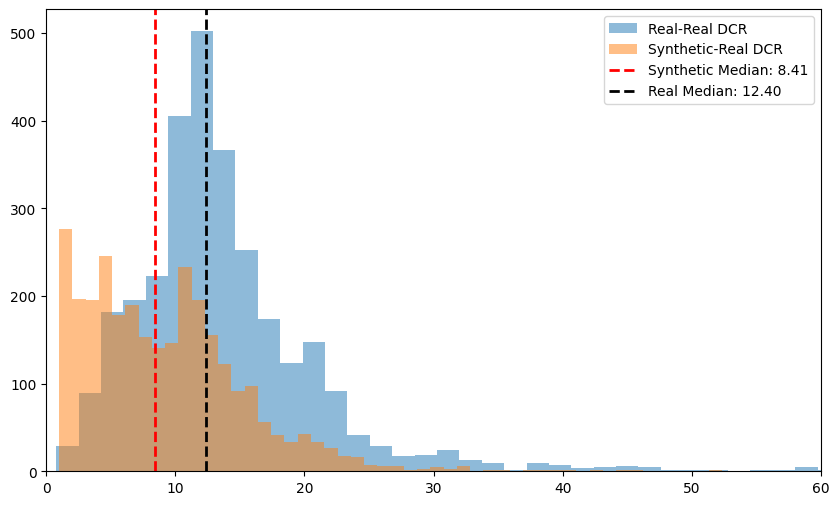

In [28]:
selected_values = synthetic_dcr_o[synthetic_dcr_o < 90]
sv = real_dcr_o[real_dcr_o < 90]
synth_median = np.median(selected_values)
real_median = np.median(sv)

plt.figure(figsize=(10, 6))

plt.hist(sv, bins = 50 ,alpha=0.5, label='Real-Real DCR')
plt.hist(selected_values, bins = 50 ,alpha=0.5, label='Synthetic-Real DCR')

plt.axvline(synth_median, color='red', linestyle='dashed', linewidth=2, label=f'Synthetic Median: {synth_median:.2f}')
plt.axvline(real_median, color='black', linestyle='dashed', linewidth=2, label=f'Real Median: {real_median:.2f}')

plt.legend()

plt.xlim(0, 60)
plt.show()

### Machine learning efficiency (MLE)

As last we try to build a simple machine learning model on the data to compare the efficiency of synthetic data with respect to the real. To do this we **train** a model on the synthetic data and test it on the real, in order to verify how efficient the synthetic data would be. We then compare the accuracy of the model with the one of a model trained and testd on the real data. As model we use a simple ``RandomForest`` classifier, using as target variable ``cloud_cover``.

In [29]:
seed = 12


df_sin['cloud_cover'] = df_sin['cloud_cover'].astype('category')
df_filtered['cloud_cover'] = df_filtered['cloud_cover'].astype('category')


valid_values = df_filtered['cloud_cover'].unique()


df_sin_filtered = df_sin[df_sin['cloud_cover'].isin(valid_values)]

X_s = df_sin.drop(['cloud_cover', 'Date'], axis=1)
y_s = df_sin['cloud_cover']

X = df_filtered.drop(['cloud_cover', 'Date'], axis=1)
y = df_filtered['cloud_cover']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

rf = RandomForestClassifier(n_estimators=100, random_state=seed)

rf.fit(X_s, y_s)

predictions = rf.predict(X_test)

print('======= Random Forest - SYNTHETIC train REAL test =======')
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print('                     Accuracy: ',round(accuracy_score(y_test, predictions),2),'\n')

rf = RandomForestClassifier(n_estimators=100, random_state=seed)

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

print('======= Random Forest - REAL train REAL test =======')
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print('                     Accuracy: ',round(accuracy_score(y_test, predictions),2),'\n')


/var/folders/k9/h78k3gpn65g5ws_c46j649n40000gn/T/ipykernel_8366/1827465982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cloud_cover'] = df_filtered['cloud_cover'].astype('category')


======= Random Forest - SYNTHETIC train REAL test =======
[[ 1  0  1  1  2  2  0  0  0]
 [ 2  3  4  1  6  7  0  0  0]
 [ 1  4  6 10 10  7  7  4  1]
 [ 0  2  4 15 17 12 14  6  2]
 [ 0  1  1  5 19 23 27 20  5]
 [ 2  0  1  8 22 73 30 22  8]
 [ 1  0  0  3  7 38 87 46 14]
 [ 0  0  1  0  7 19 42 87 24]
 [ 0  1  0  0  2  4 11 43 44]]
              precision    recall  f1-score   support

           0       0.14      0.14      0.14         7
           1       0.27      0.13      0.18        23
           2       0.33      0.12      0.18        50
           3       0.35      0.21      0.26        72
           4       0.21      0.19      0.20       101
           5       0.39      0.44      0.42       166
           6       0.40      0.44      0.42       196
           7       0.38      0.48      0.43       180
           8       0.45      0.42      0.43       105

    accuracy                           0.37       900
   macro avg       0.33      0.29      0.29       900
weighted avg       0.